In [1]:
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import tqdm
import time
import os
import wandb
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

from external_utils import format_time
from utils.data_preprocessing import preprocess_dataset_get_dataset, generate_dataset_from_loader,preprocess_dataset_get_data_loader,get_data_loader
from structure.dlgn_conv_config_structure import DatasetConfig
import numpy as np

from attacks import cleverhans_projected_gradient_descent,cleverhans_fast_gradient_method,get_locuslab_adv_per_batch,get_residue_adv_per_batch


2024-03-04 22:56:01.323184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 22:56:02.287904: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-04 22:56:02.288022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-03-04 22:56:02.288033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def generate_graph(model):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    eps = 0.3
    eps_step_size = 0.01
    number_of_adversarial_optimization_steps = 40
    update_on = 'all'
    rand_init = True
    clip_min = 0.0
    clip_max = 1.0
    residue_vname = None

    init_losses=[]
    pgd_losses=[]
    reach_end_losses=[]

    kargs = {"criterion":loss_fn,"eps":eps,"eps_step_size":eps_step_size,"steps":number_of_adversarial_optimization_steps,"update_on":update_on,'rand_init':rand_init,'clip_min':clip_min,'clip_max':clip_max,'targeted':False,'norm':np.inf,'residue_vname':residue_vname}
    loader = tqdm.tqdm(trainloader, desc='Generating Plots')
    for batch_idx, data in enumerate(loader, 0):
        (X, y) = data
        X, y = X.cuda(), y.cuda()
        kargs["labels"] = y
        init_loss = loss_fn(model(X),y)
        init_losses.append(init_loss.item())

        kargs['residue_vname']=None
        adv_x = cleverhans_projected_gradient_descent(model,X,kargs)
        pgd_at_end_loss = loss_fn(model(adv_x),y)
        pgd_losses.append(pgd_at_end_loss.item())

        kargs['residue_vname'] = "reach_edge_at_end"
        adv_x = cleverhans_projected_gradient_descent(model,X,kargs)
        reach_end_loss = loss_fn(model(adv_x),y)
        print("init_loss:{} pgd_at_end_loss:{} reach_end_loss:{}".format(init_loss,pgd_at_end_loss,reach_end_loss))
        reach_end_losses.append(reach_end_loss.item())

    xs = [i for i in range(len(init_losses))]
    plt.plot(xs, init_losses, label ='Init_Loss')
    plt.plot(xs, pgd_losses, '-.', label ='PGD Loss')
    plt.plot(xs, reach_end_losses, label ='Reach End Loss')

    plt.xlabel("Data point index")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss difference on model')
    plt.show()        

In [3]:
def generate_table_row(model,X,y,sorted_list_steps):
    relu=torch.nn.ReLU()
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    eps = 0.3
    eps_step_size = 0.01
    number_of_adversarial_optimization_steps = sorted_list_steps[0]
    update_on = 'all'
    rand_init = True
    clip_min = 0.0
    clip_max = 1.0
    residue_vname = None

    cur_row = []

    kargs = {"criterion":loss_fn,"eps":eps,"eps_step_size":eps_step_size,"steps":number_of_adversarial_optimization_steps,"update_on":update_on,'rand_init':rand_init,'clip_min':clip_min,'clip_max':clip_max,'targeted':False,'norm':np.inf,'residue_vname':residue_vname}
    kargs["labels"] = y
    init_loss = loss_fn(model(X),y).item()
    cur_row.append(init_loss)
    adv_x = X.clone()
    for i,cur_s in enumerate(sorted_list_steps):
        kargs['steps'] = cur_s
        
        kargs['residue_vname'] = "reach_edge_at_end"
        end_adv_x = cleverhans_projected_gradient_descent(model,X,kargs)
        reach_end_loss = loss_fn(model(end_adv_x),y)
        cur_row.append(reach_end_loss.item())

        kargs['residue_vname']=None
        adv_x = cleverhans_projected_gradient_descent(model,X,kargs)
        pgd_at_end_loss = loss_fn(model(adv_x),y)
        cur_row.append(pgd_at_end_loss.item())
        # adv_x = torch.clamp(X,X-eps,X+eps)
        assert (((adv_x - X) > -(eps+1e-5)).all() and ( (adv_x-X) < (eps+1e-5)).all()),'Wrong'
        diff = adv_x - X
        tttmp = torch.where(diff >= 0,(X + eps - adv_x),(adv_x - (X - eps)))
        eps_norm = torch.norm(tttmp,p=1)
        if(cur_s == 120):
            print(eps_norm)
        cur_row.append(eps_norm.item())

    return cur_row
           

In [4]:
def generate_table(model,loader,sorted_list_steps,num_batches=100):
    rows = []
    loader = tqdm.tqdm(loader, desc='Generating Table Data')
    for batch_idx, data in enumerate(loader, 0):
        (X, y) = data
        X, y = X.cuda(), y.cuda()
        cur_row = generate_table_row(model,X,y,sorted_list_steps)

        rows.append(cur_row)
        if(batch_idx > num_batches):
            break
    
    return rows

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
data_config = DatasetConfig(
                'mnist', is_normalize_data=True, valid_split_size=0.1, batch_size=1, list_of_classes=None,custom_dataset_path=None)

trainloader, _, testloader = preprocess_dataset_get_data_loader(
                data_config, "dnn", verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

np.max(filtered_X_train) 255.0
filtered_X_train  1.0 0.0
filtered_X_test  1.0 0.0


In [7]:
tst = next(iter(trainloader))
tst[0].size()

torch.Size([1, 1, 28, 28])

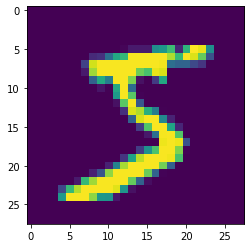

In [8]:
img = tst[0][0]
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [9]:
net = torch.load("root/model/save/mnist/adversarial_training/MT_fc_dnn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt")
net = net.to(device)

In [10]:
sorted_list_steps = [40,45,50,55,60,70,75,80,85,90,95,100,105,110,115,120]
loss_table = generate_table(net,trainloader,sorted_list_steps)

Generating Table Data:   0%|          | 1/60000 [00:26<443:47:05, 26.63s/it]

tensor(105.0774, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 2/60000 [00:52<433:07:17, 25.99s/it]

tensor(37.2107, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 3/60000 [01:07<350:32:35, 21.03s/it]

tensor(143.9602, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 4/60000 [01:31<369:58:15, 22.20s/it]

tensor(173.7784, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 5/60000 [01:55<381:43:03, 22.90s/it]

tensor(159.1756, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 6/60000 [02:19<389:04:25, 23.35s/it]

tensor(69.5719, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 7/60000 [02:43<393:44:08, 23.63s/it]

tensor(167.2057, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 8/60000 [03:05<381:23:57, 22.89s/it]

tensor(87.3839, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 9/60000 [03:10<288:21:23, 17.30s/it]

tensor(74.8886, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 10/60000 [03:31<309:53:18, 18.60s/it]

tensor(187.5356, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 11/60000 [03:57<345:18:13, 20.72s/it]

tensor(59.2048, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 12/60000 [04:22<369:43:36, 22.19s/it]

tensor(22.0250, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 13/60000 [04:48<386:45:10, 23.21s/it]

tensor(91.9577, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 14/60000 [05:13<398:16:04, 23.90s/it]

tensor(171.7657, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 15/60000 [05:27<347:18:23, 20.84s/it]

tensor(215.4424, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 16/60000 [05:51<363:59:33, 21.85s/it]

tensor(33.3351, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 17/60000 [06:15<375:24:39, 22.53s/it]

tensor(91.2401, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 18/60000 [06:40<383:29:22, 23.02s/it]

tensor(185.8861, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 19/60000 [07:04<389:11:45, 23.36s/it]

tensor(165.4005, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 20/60000 [07:28<392:43:20, 23.57s/it]

tensor(32.9263, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 21/60000 [07:33<299:47:43, 17.99s/it]

tensor(161.5861, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 22/60000 [07:50<296:46:38, 17.81s/it]

tensor(181.4350, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 23/60000 [08:16<335:17:55, 20.13s/it]

tensor(165.3625, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 24/60000 [08:41<362:27:00, 21.76s/it]

tensor(196.4941, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 25/60000 [09:07<381:25:58, 22.90s/it]

tensor(38.8694, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 26/60000 [09:32<394:23:21, 23.67s/it]

tensor(111.0544, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 27/60000 [09:48<354:22:54, 21.27s/it]

tensor(158.2754, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 28/60000 [10:12<366:21:17, 21.99s/it]

tensor(32.2122, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 29/60000 [10:36<377:06:16, 22.64s/it]

tensor(152.3307, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 30/60000 [11:00<384:55:02, 23.11s/it]

tensor(144.2590, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 31/60000 [11:24<390:10:53, 23.42s/it]

tensor(45.8749, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 32/60000 [11:48<394:21:24, 23.67s/it]

tensor(48.2839, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 33/60000 [11:56<314:29:48, 18.88s/it]

tensor(159.5534, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 34/60000 [12:13<305:38:23, 18.35s/it]

tensor(110.6557, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 35/60000 [12:39<341:35:36, 20.51s/it]

tensor(33.4797, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 36/60000 [13:04<366:54:23, 22.03s/it]

tensor(100.6031, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 37/60000 [13:30<384:26:48, 23.08s/it]

tensor(150.8667, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 38/60000 [13:55<396:46:20, 23.82s/it]

tensor(43.3259, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 39/60000 [14:11<357:56:25, 21.49s/it]

tensor(126.1673, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 40/60000 [14:35<369:32:53, 22.19s/it]

tensor(166.5661, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 41/60000 [14:59<379:31:33, 22.79s/it]

tensor(206.9876, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 42/60000 [15:24<386:25:09, 23.20s/it]

tensor(123.9462, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 43/60000 [15:48<391:27:31, 23.50s/it]

tensor(154.4298, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 44/60000 [16:12<395:04:06, 23.72s/it]

tensor(22.3590, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 45/60000 [16:20<314:05:08, 18.86s/it]

tensor(40.5501, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 46/60000 [16:36<303:49:37, 18.24s/it]

tensor(164.1575, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 47/60000 [17:02<340:15:10, 20.43s/it]

tensor(49.8846, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 48/60000 [17:27<365:31:26, 21.95s/it]

tensor(51.5806, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 49/60000 [17:53<383:33:52, 23.03s/it]

tensor(134.2596, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 50/60000 [18:18<396:11:26, 23.79s/it]

tensor(38.6586, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 51/60000 [18:35<360:15:07, 21.63s/it]

tensor(53.6647, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 52/60000 [18:59<373:46:14, 22.45s/it]

tensor(110.1528, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 53/60000 [19:24<383:08:51, 23.01s/it]

tensor(147.3059, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 54/60000 [19:48<389:26:01, 23.39s/it]

tensor(160.9924, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 55/60000 [20:12<394:19:05, 23.68s/it]

tensor(161.0254, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 56/60000 [20:37<397:18:49, 23.86s/it]

tensor(106.0211, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 57/60000 [20:43<310:01:27, 18.62s/it]

tensor(34.3579, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 58/60000 [20:59<298:00:35, 17.90s/it]

tensor(157.6951, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 59/60000 [21:25<336:36:29, 20.22s/it]

tensor(128.5106, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 60/60000 [21:50<363:12:04, 21.81s/it]

tensor(101.8095, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 61/60000 [22:16<381:39:00, 22.92s/it]

tensor(113.7210, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 62/60000 [22:42<394:48:07, 23.71s/it]

tensor(150.0000, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 63/60000 [22:59<361:28:36, 21.71s/it]

tensor(137.3468, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 64/60000 [23:23<375:19:01, 22.54s/it]

tensor(29.1656, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 65/60000 [23:47<383:48:07, 23.05s/it]

tensor(165.4066, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 66/60000 [24:11<389:34:18, 23.40s/it]

tensor(182.7123, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 67/60000 [24:36<393:49:28, 23.66s/it]

tensor(154.9458, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 68/60000 [25:00<396:21:45, 23.81s/it]

tensor(207.6122, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 69/60000 [25:06<309:08:45, 18.57s/it]

tensor(50.2712, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 70/60000 [25:24<305:20:22, 18.34s/it]

tensor(23.9830, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 71/60000 [25:50<341:25:39, 20.51s/it]

tensor(201.6020, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 72/60000 [26:15<366:40:17, 22.03s/it]

tensor(36.0693, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 73/60000 [26:41<384:28:22, 23.10s/it]

tensor(198.8777, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 74/60000 [27:06<396:50:15, 23.84s/it]

tensor(156.3167, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 75/60000 [27:22<356:48:23, 21.44s/it]

tensor(30.7197, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 76/60000 [27:46<369:26:30, 22.19s/it]

tensor(37.4160, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 77/60000 [28:10<378:27:49, 22.74s/it]

tensor(80.7165, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 78/60000 [28:34<384:59:00, 23.13s/it]

tensor(189.2569, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 79/60000 [28:58<390:12:27, 23.44s/it]

tensor(171.9965, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 80/60000 [29:23<393:53:23, 23.66s/it]

tensor(106.3064, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 81/60000 [29:29<310:19:18, 18.64s/it]

tensor(134.7221, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 82/60000 [29:47<306:14:35, 18.40s/it]

tensor(33.2921, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 83/60000 [30:13<342:07:39, 20.56s/it]

tensor(29.1685, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 84/60000 [30:38<367:07:05, 22.06s/it]

tensor(114.5856, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 85/60000 [31:04<384:49:38, 23.12s/it]

tensor(192.2599, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 86/60000 [31:30<397:05:26, 23.86s/it]

tensor(105.2098, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 87/60000 [31:45<356:51:22, 21.44s/it]

tensor(191.2550, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 88/60000 [32:09<369:43:07, 22.22s/it]

tensor(168.0987, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 89/60000 [32:34<379:27:01, 22.80s/it]

tensor(36.0032, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 90/60000 [32:58<386:25:20, 23.22s/it]

tensor(169.8712, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 91/60000 [33:22<391:04:54, 23.50s/it]

tensor(90.6893, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 92/60000 [33:46<394:34:28, 23.71s/it]

tensor(140.5765, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 93/60000 [33:53<308:25:08, 18.53s/it]

tensor(143.2749, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 94/60000 [34:08<293:14:52, 17.62s/it]

tensor(152.3694, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 95/60000 [34:34<332:59:53, 20.01s/it]

tensor(78.5934, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 96/60000 [34:59<360:46:56, 21.68s/it]

tensor(42.3941, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 97/60000 [35:25<380:14:33, 22.85s/it]

tensor(114.5416, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 98/60000 [35:50<393:55:33, 23.67s/it]

tensor(129.7137, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 99/60000 [36:08<362:42:14, 21.80s/it]

tensor(187.4914, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 100/60000 [36:30<365:50:12, 21.99s/it]

tensor(107.6252, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 101/60000 [36:54<376:35:36, 22.63s/it]

tensor(37.7700, device='cuda:0', grad_fn=<NormBackward1>)


Generating Table Data:   0%|          | 101/60000 [37:19<368:53:00, 22.17s/it]

tensor(45.8259, device='cuda:0', grad_fn=<NormBackward1>)


In [11]:
cols = ['init_loss']
for ii in sorted_list_steps:
    cols.append('Reach_end@{}'.format(ii))
    cols.append('PGD@{}'.format(ii))
    cols.append('EPS_norm@{}'.format(ii))
loss_table.insert(0,cols)

In [12]:
loss_table

[['init_loss',
  'Reach_end@40',
  'PGD@40',
  'EPS_norm@40',
  'Reach_end@45',
  'PGD@45',
  'EPS_norm@45',
  'Reach_end@50',
  'PGD@50',
  'EPS_norm@50',
  'Reach_end@55',
  'PGD@55',
  'EPS_norm@55',
  'Reach_end@60',
  'PGD@60',
  'EPS_norm@60',
  'Reach_end@70',
  'PGD@70',
  'EPS_norm@70',
  'Reach_end@75',
  'PGD@75',
  'EPS_norm@75',
  'Reach_end@80',
  'PGD@80',
  'EPS_norm@80',
  'Reach_end@85',
  'PGD@85',
  'EPS_norm@85',
  'Reach_end@90',
  'PGD@90',
  'EPS_norm@90',
  'Reach_end@95',
  'PGD@95',
  'EPS_norm@95',
  'Reach_end@100',
  'PGD@100',
  'EPS_norm@100',
  'Reach_end@105',
  'PGD@105',
  'EPS_norm@105',
  'Reach_end@110',
  'PGD@110',
  'EPS_norm@110',
  'Reach_end@115',
  'PGD@115',
  'EPS_norm@115',
  'Reach_end@120',
  'PGD@120',
  'EPS_norm@120'],
 [2.2071685791015625,
  2.642873764038086,
  2.810455322265625,
  120.45211791992188,
  2.793226480484009,
  2.81203031539917,
  106.43936157226562,
  2.79187273979187,
  2.7025065422058105,
  102.72557067871094,
  2.

In [13]:
import csv
with open('root/losses/debug_larger_steps.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(loss_table)
# with open("root/losses/debug.csv", "wb") as csv_file:
#     writer = csv.writer(csv_file, delimiter=',')
#     for line in loss_table:
#         print(line)
#         writer.writerow(line)

: 

In [51]:
net = torch.load("root/model/save/mnist/adversarial_training/MT_fc_dnn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir_epoch_0.pt")
net = net.to(device)

In [ ]:
generate_graph(net)

Generating Plots: 100%|██████████| 3750/3750 [42:56<00:00,  1.46it/s]


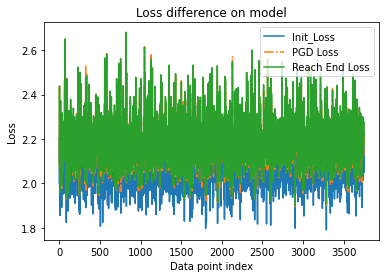

In [ ]:
net = torch.load("root/model/save/mnist/adversarial_training/MT_fc_dnn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir_epoch_5.pt")
net = net.to(device)
generate_graph(net)

Generating Plots: 100%|██████████| 3750/3750 [43:20<00:00,  1.44it/s]


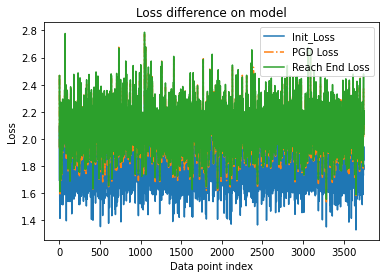

In [ ]:
net = torch.load("root/model/save/mnist/adversarial_training/MT_fc_dnn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir_epoch_10.pt")
net = net.to(device)
generate_graph(net)

In [ ]:
net = torch.load("root/model/save/mnist/adversarial_training/MT_fc_dnn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir_epoch_15.pt")
net = net.to(device)
generate_graph(net)

Generating Plots:   0%|          | 0/3750 [00:00<?, ?it/s]

Generating Plots:  71%|███████   | 2664/3750 [30:39<13:55,  1.30it/s]

Generating Plots: 100%|██████████| 3750/3750 [42:27<00:00,  1.47it/s]


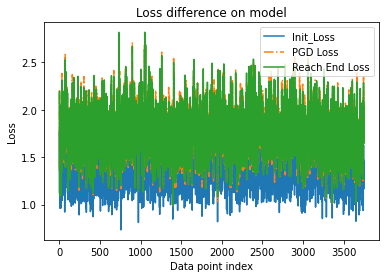

In [ ]:
net = torch.load("root/model/save/mnist/adversarial_training/MT_fc_dnn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt")
net = net.to(device)
generate_graph(net)